In [111]:
import pandas as pd 
import numpy as np
import datetime as dt
import requests
import matplotlib as mlt
import seaborn as sns
from scipy import stats
import warnings
#import tweepy
#from tweepy import OAuthHandler
import matplotlib.pyplot as plt
import json
import os
%matplotlib inline

# gathering the data

## twitter-archive-enhanced

In [9]:
archive_df=pd.read_csv('twitter-archive-enhanced.csv')
archive_df.shape

(2356, 17)

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json copy.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass

print(fails_dict)


## api_df

In [10]:
df_json_list=[]
with open('tweet-json copy','r') as tweetjson:
    for line in tweetjson:
        line = json.loads(line.strip())
        id= line["id"]
        retweet_count=line["retweet_count"]
        favorite_count=line["favorite_count"]
        df_json_list.append({'id':id,'retweet_count':retweet_count,'favorite_count':favorite_count })
api_df=pd.DataFrame(df_json_list,columns = ['id','retweet_count','favorite_count'])

## image_predictions_df

In [15]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image = requests.get(url)
folder_name='image_predictions'
os.mkdir(folder_name)
with open (os.path.join(folder_name,
                        url.split('/')[-1]),mode='wb')as file:
    file.write(image.content)
image_predictions_df = pd.read_csv('image_predictions/image-predictions.tsv',sep='\t')
image_predictions_df.shape

(2075, 12)

# assessing and cleaning 

In [16]:
api_df.shape

(2354, 3)

**1- identify and remove the rows that contains the retweet and replies using retweeted_status_id,in_reply_to_status_id by index from archive data set**

copying data

In [17]:
archive_df_original=archive_df.copy()

In [19]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

**remove the rows that contains the retweet and replies**

In [20]:
dropped_values=archive_df[archive_df['retweeted_status_id'].notnull()|archive_df['in_reply_to_status_id'].notnull()]
archive_df_drop=archive_df.drop(dropped_values.index)


**checking the deletion**

In [21]:
archive_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

**checking the classification of dogs**

In [37]:
for column in ['doggo','floofer','pupper','puppo']:
    print(column)
    print(archive_df_drop[column].value_counts())
    print('\n')

doggo
None     2014
doggo      83
Name: doggo, dtype: int64


floofer
None       2087
floofer      10
Name: floofer, dtype: int64


pupper
None      1867
pupper     230
Name: pupper, dtype: int64


puppo
None     2073
puppo      24
Name: puppo, dtype: int64




**non-value cells in the 4 columns of the classification and replaced them with empty string**

In [38]:
archive_df_drop.iloc[:, -4: ] = archive_df_drop.iloc[:, -4: ].replace('None','')

**checking the replacement of non values**

In [40]:
for column in ['doggo','floofer','pupper','puppo']:
    print(column)
    print(archive_df_drop[column].value_counts())
    print('\n')

doggo
         2014
doggo      83
Name: doggo, dtype: int64


floofer
           2087
floofer      10
Name: floofer, dtype: int64


pupper
          1867
pupper     230
Name: pupper, dtype: int64


puppo
         2073
puppo      24
Name: puppo, dtype: int64




**removing un-needed columns**

In [41]:
archive_df_drop=archive_df_drop.drop(columns=['retweeted_status_id','retweeted_status_timestamp','retweeted_status_user_id',
                                              'in_reply_to_status_id','in_reply_to_user_id'],errors='ignore')

**making new column (dogs_classification) contains the four columns of classification and checking the values after merging the columns values** 

In [42]:
archive_df_drop['dogs_classification'] = archive_df_drop.apply(lambda row: row['doggo'] + 
                                                               row['floofer']+row['pupper']+row['puppo'], axis=1)
archive_df_drop['dogs_classification'].value_counts()

                1761
pupper           221
doggo             72
puppo             23
floofer            9
doggopupper        9
doggopuppo         1
doggofloofer       1
Name: dogs_classification, dtype: int64

**collecting the double class and droping them from the data**

In [43]:
double_class = archive_df_drop[(archive_df_drop['dogs_classification'] =='doggopupper') 
                               | (archive_df_drop['dogs_classification'] =='doggofloofer')
                               |(archive_df_drop['dogs_classification'] =='doggopuppo')]
archive_df_drop=archive_df_drop.drop(double_class.index)

**checking the rating numerator and denominator**

In [50]:
print(archive_df_drop['rating_numerator'].describe())
print('\n')
print(archive_df_drop['rating_denominator'].describe())
print('\n')

count    2086.000000
mean       12.194151
std        40.470982
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64


count    2086.000000
mean       10.451103
std         6.662487
min         2.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64




**droping rating denominator other than 10 value**

In [51]:
denomin_drop = archive_df_drop[archive_df_drop['rating_denominator']!=10]
archive_df_drop=archive_df_drop.drop(denomin_drop.index)

**checking droping rating denominator other than 10 value**

In [53]:
print(archive_df_drop['rating_denominator'].describe())

count    2069.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: rating_denominator, dtype: float64


**checking name variable**

In [54]:
archive_df_drop['name'].value_counts()

None       586
a           54
Charlie     11
Lucy        11
Cooper      10
          ... 
Sky          1
Zoe          1
Leela        1
Sephie       1
Bowie        1
Name: name, Length: 949, dtype: int64

**after checking i recommend replacing the 'A' and 'none' values with null to be consistent**

In [55]:
archive_df_drop.iloc[:, -8: ] = archive_df_drop.iloc[:, -8: ].replace(['None','a'],'null')

**checking replacing**

In [57]:
archive_df_drop['name'].value_counts()

null        640
Charlie      11
Lucy         11
Oliver       10
Cooper       10
           ... 
Meyer         1
Sky           1
Zoe           1
Leela         1
Ralphson      1
Name: name, Length: 948, dtype: int64

**checking the variables format**

In [56]:
archive_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tweet_id             2069 non-null   int64 
 1   timestamp            2069 non-null   object
 2   source               2069 non-null   object
 3   text                 2069 non-null   object
 4   expanded_urls        2066 non-null   object
 5   rating_numerator     2069 non-null   int64 
 6   rating_denominator   2069 non-null   int64 
 7   name                 2069 non-null   object
 8   doggo                2069 non-null   object
 9   floofer              2069 non-null   object
 10  pupper               2069 non-null   object
 11  puppo                2069 non-null   object
 12  dogs_classification  2069 non-null   object
dtypes: int64(3), object(10)
memory usage: 226.3+ KB


**timestamp have to be date time format according to the code below**

In [58]:
archive_df_drop['timestamp'] = pd.to_datetime(archive_df_drop['timestamp'])

**checking the variables format**

In [59]:
archive_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tweet_id             2069 non-null   int64              
 1   timestamp            2069 non-null   datetime64[ns, UTC]
 2   source               2069 non-null   object             
 3   text                 2069 non-null   object             
 4   expanded_urls        2066 non-null   object             
 5   rating_numerator     2069 non-null   int64              
 6   rating_denominator   2069 non-null   int64              
 7   name                 2069 non-null   object             
 8   doggo                2069 non-null   object             
 9   floofer              2069 non-null   object             
 10  pupper               2069 non-null   object             
 11  puppo                2069 non-null   object             
 12  dogs_classification 

**copy image prediction data**

In [60]:
image_predictions_original=image_predictions_df.copy()

**checking image_predictions data**

In [61]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


**firstly keep the observation with the triple true in the boolean columns with true value**

In [62]:
image_predictions_df = image_predictions_df[(image_predictions_df['p1_dog'] ==True) & (image_predictions_df['p2_dog'] ==True)
                                            & (image_predictions_df['p3_dog'] ==True)]

**rename the variable names to be presentable more**

In [63]:
image_predictions_df=image_predictions_df.rename(columns={"tweet_id":"tweet_id","jpg_url":"jpg_url","img_num":"img_num",
                                                          "p1":"1st_prediction","p1_conf":"1st_prediction_conf",
                                                          "p1_dog":"1st_prediction_dog","p2":"2nd_prediction",
                                                          "p2_conf":"2nd_prediction_conf","p2_dog":"2nd_prediction_dog",
                                                          "p3":"3rd_prediction","p3_conf":"3rd_prediction_conf",
                                                          "p3_dog":"3rd_prediction_dog"}) 

**checking the renaming**

In [64]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 2073
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tweet_id             1243 non-null   int64  
 1   jpg_url              1243 non-null   object 
 2   img_num              1243 non-null   int64  
 3   1st_prediction       1243 non-null   object 
 4   1st_prediction_conf  1243 non-null   float64
 5   1st_prediction_dog   1243 non-null   bool   
 6   2nd_prediction       1243 non-null   object 
 7   2nd_prediction_conf  1243 non-null   float64
 8   2nd_prediction_dog   1243 non-null   bool   
 9   3rd_prediction       1243 non-null   object 
 10  3rd_prediction_conf  1243 non-null   float64
 11  3rd_prediction_dog   1243 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 100.8+ KB


**keep data in archive df with images only as requested**

In [65]:
tweets_with_image = list(image_predictions_df.tweet_id.unique())
len(tweets_with_image) == archive_df_drop.tweet_id.isin(tweets_with_image).sum()
archive_df_drop = archive_df_drop[archive_df_drop.tweet_id.isin(tweets_with_image)]
len(tweets_with_image) == archive_df_drop.tweet_id.isin(tweets_with_image).sum()

False

**checking api df**

In [66]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


**rename the variable names to be consistent with other two**

In [67]:
api_df=api_df.rename(columns={"id": "tweet_id", "retweet_count": "retweet_count","favourite_count":"favourite_count"})

**copy api_df**

In [68]:
api_df_original=api_df.copy()

**merge the tweets data set to be a one unit related data**

In [69]:
tweet_data = pd.merge((archive_df_drop[['tweet_id','timestamp','source','text','expanded_urls']]),
                      api_df, on='tweet_id', how='inner')

**merge the dogs data set to be a one unit related data**

In [89]:
dogs_data=pd.merge(archive_df_drop[['tweet_id','rating_numerator',
                                    'rating_denominator','name','doggo','pupper','puppo','floofer','dogs_classification']],
                   image_predictions_df,on='tweet_id',how='inner')

**merge all data set to be a one unit master data as requied**

In [90]:
merge=pd.merge(tweet_data,dogs_data,on='tweet_id',how='inner')

**prepare data set for analysing by dog class for classed only**

In [91]:
dog_class=merge[(merge['doggo']=='doggo')+(merge['pupper']=='pupper')+(merge['puppo']=='puppo')+(merge['floofer']=='floofer')]
dog_class['dogs_classification'].value_counts()

pupper     119
doggo       39
puppo       18
floofer      6
Name: dogs_classification, dtype: int64

**insight on histogram for dog class to show the dominant class in the data**

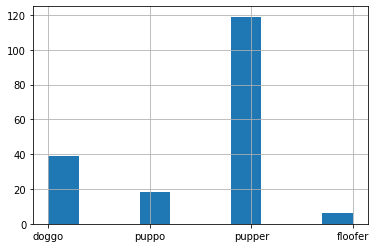

In [92]:
dog_class['dogs_classification'].hist()

**insight on retweet_count,favorite_count**

In [93]:
merge["retweet_count"].describe()

count     1174.000000
mean      2758.096252
std       4535.201131
min         16.000000
25%        648.500000
50%       1418.000000
75%       3226.250000
max      56625.000000
Name: retweet_count, dtype: float64

In [94]:
merge["favorite_count"].describe()

count      1174.000000
mean       9332.022147
std       12623.379263
min          81.000000
25%        2219.250000
50%        4540.000000
75%       11734.750000
max      132810.000000
Name: favorite_count, dtype: float64

**graphing both retweet_count vs favorite_count**

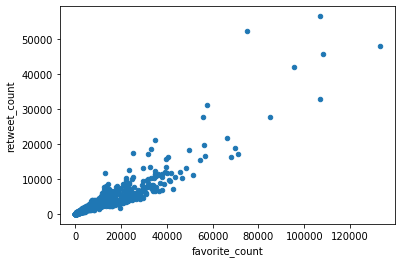

In [95]:
merge.plot(x="favorite_count",y="retweet_count",kind='scatter')

**describing the numerator and denominator data to get eye on the range and the resulting numbers**

In [96]:
rating_analyze=merge.groupby(['dogs_classification']).describe()[['rating_numerator','rating_denominator']]

In [97]:
rating_analyze.max()

rating_numerator    count    992.000000
                    mean      12.055556
                    std        1.978628
                    min       10.000000
                    25%       12.000000
                    50%       12.500000
                    75%       13.000000
                    max       27.000000
rating_denominator  count    992.000000
                    mean      10.000000
                    std        0.000000
                    min       10.000000
                    25%       10.000000
                    50%       10.000000
                    75%       10.000000
                    max       10.000000
dtype: float64

**checking the confidence % on predictions done to decide on graphing the one more reliable**

In [98]:
prediction_confidence=merge.groupby(['dogs_classification']).describe()[['1st_prediction_conf','2nd_prediction_conf','3rd_prediction_conf']]

In [99]:
prediction_confidence.max()

1st_prediction_conf  count    992.000000
                     mean       0.702760
                     std        0.307513
                     min        0.359860
                     25%        0.544080
                     50%        0.755945
                     75%        0.957464
                     max        0.999876
2nd_prediction_conf  count    992.000000
                     mean       0.190693
                     std        0.160702
                     min        0.008758
                     25%        0.114839
                     50%        0.168747
                     75%        0.297003
                     max        0.467678
3rd_prediction_conf  count    992.000000
                     mean       0.071525
                     std        0.058315
                     min        0.002140
                     25%        0.033726
                     50%        0.071732
                     75%        0.097503
                     max        0.271042
dtype: float64

**graphing the most reprsentative specie prediction**

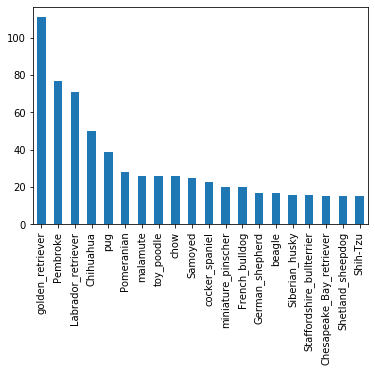

In [135]:
merge['1st_prediction'].value_counts().head(20).plot.bar()

**time stamp eye on the peak of tweeting and activity**

Text(0, 0.5, 'count of tweets per day hours')

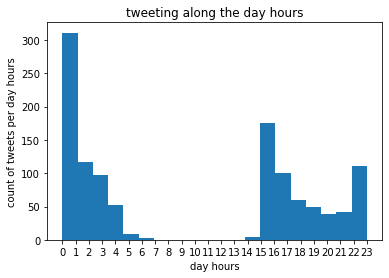

In [134]:
timing=merge['timestamp'].dt.hour
plt.hist(timing,bins=20)
plt.xticks(list(range(0,24)))
plt.title('tweeting along the day hours')
plt.xlabel('day hours')
plt.ylabel('count of tweets per day hours')

In [130]:
archive_df_original.to_csv('twitter_archive_enhanced.csv',index=False)
image_predictions_original.to_csv('image_predictions.csv',index=False)
api_df_original.to_csv('tweet-json.csv',index=False)
tweet_data.to_csv('tweet_data.csv',index=False)
dogs_data.to_csv('dogs_data.csv',index=False)
merge.to_csv('twitter_archive_master.csv',index=False)